
# Multi-Frame Assignment example
This notebook includes an example of the Multi-Frame Assignment (MFA) algorithm [#]_.

The multi-frame assignment algorithm maintains and prunes hypotheses over *N*-Scans. This enables
the global optimum assignment choice to be selected over *N* multiple frames/timesteps/scans.


## Global parameters



In [1]:
import numpy as np
from scipy.stats import chi2

np.random.seed(2001)  # Used to set the seed for the numpy random number generator

prob_detect = 0.9  # Prob. of detection
gate_level = 8  # Gate level
prob_gate = chi2.cdf(gate_level, 2)  # Prob. of gating, computed from gate level for hypothesiser
v_bounds = np.array([[-10, 40], [-10, 40]])  # Surveillance area bounds
lambdaV = 5  # Mean number of clutter points over the entire surveillance area
lambda_ = lambdaV/(np.prod(v_bounds[:, 0] - v_bounds[:, 1]))  # Clutter density per unit volume
slide_window = 3  # Slide window; used by MFA data associator

## Plotting functions
First we'll need some custom plotting functions, used to show the different assignments
present within the slide window.



In [2]:
def plot_covar(state, ax, color=None):
    w, v = np.linalg.eig(
        measurement_model.matrix() @ state.covar @ measurement_model.matrix().T)
    max_ind = np.argmax(w)
    min_ind = np.argmin(w)
    orient = np.arctan2(v[1, max_ind], v[0, max_ind])
    ellipse = Ellipse(xy=state.state_vector[(0, 2), 0],
                      width=2 * np.sqrt(w[max_ind]),
                      height=2 * np.sqrt(w[min_ind]),
                      angle=np.rad2deg(orient),
                      alpha=0.2,
                      color=color)
    ax.add_artist(ellipse)
    return ellipse


def plot_tracks(tracks, ax, slide_window=None):
    artists = []
    for plot_style, track in zip(('r-', 'b-'), tracks):
        mini_tracks = []
        hist_window = len(track) if (slide_window is None or slide_window > len(track)) else slide_window
        for component in track.state.components:
            child_tag = component.tag
            parents = []
            for j in range(1, hist_window):
                parent = next(comp for comp in track.states[-(j+1)].components
                              if comp.tag == child_tag[:-j])
                parents.append(parent)
            parents.reverse()
            parents.append(component)
            mini_tracks.append(parents)

        drawn_states = set()
        for mini_track in mini_tracks:
            # Avoid re-plotting drawn trajectory
            states_to_plot = [state for state in mini_track if state not in drawn_states]
            # Insert state before so line is drawn
            if len(states_to_plot) < len(mini_track):
                states_to_plot.insert(0, mini_track[-(len(states_to_plot)+1)])
            artists.extend(ax.plot([state.state_vector[0, 0] for state in states_to_plot],
                                   [state.state_vector[2, 0] for state in states_to_plot],
                                   plot_style))
            # Avoid re-plotting drawn error ellipses
            for state in set(states_to_plot) - drawn_states:
                artists.append(plot_covar(state, ax, plot_style[0]))
                drawn_states.add(state)

    return artists

## Models
Create models for target motion $[x \ \dot{x} \ y \ \dot{y}]$ with near constant velocity
and measurements $[x \ y]$.



In [3]:
from stonesoup.models.transition.linear import (
    CombinedLinearGaussianTransitionModel, ConstantVelocity)
from stonesoup.models.measurement.linear import LinearGaussian

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])
measurement_model = LinearGaussian(ndim_state=4, mapping=(0, 2),
                                   noise_covar=np.array([[0.7**2, 0],
                                                         [0, 0.7**2]]))

## Simulate ground truth
Simulate two targets moving at near constant velocity, crossing each other.



In [4]:
import datetime
from ordered_set import OrderedSet

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
truths = OrderedSet()
start_time = datetime.datetime.now()

truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])
for k in range(1, 41):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=datetime.timedelta(seconds=1)),
        timestamp=start_time+datetime.timedelta(seconds=k)))
truths.add(truth)

truth = GroundTruthPath([GroundTruthState([0, 1, 20, -1], timestamp=start_time)])
for k in range(1, 41):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=datetime.timedelta(seconds=1)),
        timestamp=start_time+datetime.timedelta(seconds=k)))
_ = truths.add(truth)

truth = GroundTruthPath([GroundTruthState([0, 1, 10, 10], timestamp=start_time)])
for k in range(1, 41):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=datetime.timedelta(seconds=1)),
        timestamp=start_time+datetime.timedelta(seconds=k)))
truths.add(truth)

2

## Simulate measurements
Simulate both measurements and clutter, using parameters and models.



In [5]:
from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter

scans = []
for k in range(40):
    detections = OrderedSet()

    for truth in truths:
        # Generate actual detection from the state with a chance that no detection is received.
        if np.random.rand() <= prob_detect:
            measurement = measurement_model.function(truth[k], noise=True)
            detections.add(TrueDetection(state_vector=measurement,
                                         groundtruth_path=truth,
                                         timestamp=truth[k].timestamp))

        # Generate clutter at this time-step
        truth_x = truth[k].state_vector[0]
        truth_y = truth[k].state_vector[2]
        for _ in range(np.random.poisson(lambdaV)):
            x = np.random.uniform(*v_bounds[0, :])
            y = np.random.uniform(*v_bounds[1, :])
            detections.add(Clutter([[x], [y]], timestamp=truth[k].timestamp))
    scans.append(detections)

## Tracking Components



For predictor and updater a linear Kalman filter.



In [6]:
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater

predictor = KalmanPredictor(transition_model)
updater = KalmanUpdater(measurement_model)

For Hypothesiser and Data Associator, the MFA components will be used, wrapping
a PDA hypothesiser.



In [7]:
from stonesoup.dataassociator.mfa import MFADataAssociator
from stonesoup.hypothesiser.mfa import MFAHypothesiser
from stonesoup.hypothesiser.probability import PDAHypothesiser

hypothesiser = PDAHypothesiser(predictor, updater, lambda_, prob_gate=prob_gate, prob_detect=prob_detect)
hypothesiser = MFAHypothesiser(hypothesiser)
data_associator = MFADataAssociator(hypothesiser, slide_window=slide_window)

## Estimate
Initiate priors and tracks. With MFA, a Gaussian mixture is used, where the component
represents the estimate as updated using the detections (or missed detection) assignments
as recorded on the components tag.



In [8]:
from stonesoup.types.state import TaggedWeightedGaussianState
from stonesoup.types.track import Track
from stonesoup.types.mixture import GaussianMixture
from stonesoup.types.numeric import Probability

prior1 = GaussianMixture([TaggedWeightedGaussianState([[0], [1], [0], [1]],
                                                      np.diag([1.5, 0.5, 1.5, 0.5]),
                                                      timestamp=start_time,
                                                      weight=Probability(1), tag=[])])
prior2 = GaussianMixture([TaggedWeightedGaussianState([[0], [1], [20], [-1]],
                                                      np.diag([1.5, 0.5, 1.5, 0.5]),
                                                      timestamp=start_time,
                                                      weight=Probability(1), tag=[])])
prior3 = GaussianMixture([TaggedWeightedGaussianState([[0], [1], [20], [10]],
                                                      np.diag([1.5, 0.5, 1.5, 0.5]),
                                                      timestamp=start_time,
                                                      weight=Probability(1), tag=[])])
tracks = OrderedSet((Track([prior1]), Track([prior2]), Track([prior3])))

And finally run through the scans, and plot the track and assignments
within slide window at each frame/timestep.



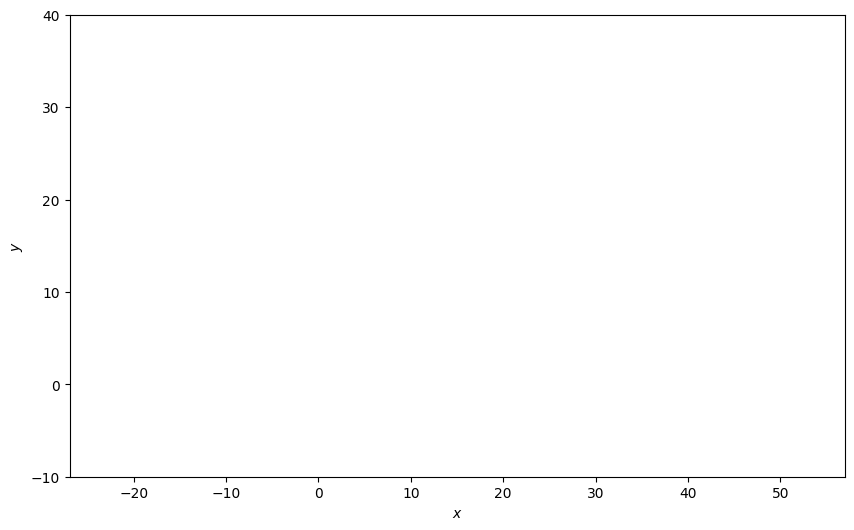

In [9]:
from matplotlib import animation
from matplotlib.patches import Ellipse
import matplotlib

matplotlib.rcParams['animation.html'] = 'jshtml'

from stonesoup.plotter import Plotter
from stonesoup.types.update import GaussianMixtureUpdate

plotter = Plotter()

frames = []
for n, detections in enumerate(scans):
    artists = []
    timestamp = start_time + datetime.timedelta(seconds=n)
    associations = data_associator.associate(tracks, detections, timestamp)

    for track, hypotheses in associations.items():
        components = []
        for hypothesis in hypotheses:
            if not hypothesis:
                components.append(hypothesis.prediction)
            else:
                update = updater.update(hypothesis)
                components.append(update)
        track.append(GaussianMixtureUpdate(components=components, hypothesis=hypotheses))

    plotter.ax.set_xlabel("$x$")
    plotter.ax.set_ylabel("$y$")
    plotter.ax.set_xlim(*v_bounds[0])
    plotter.ax.set_ylim(*v_bounds[1])

    artists.extend(plotter.plot_ground_truths([truth[:n+1] for truth in truths], [0, 2]))
    artists.extend(plotter.plot_measurements(detections, [0, 2], measurement_model))
    # Plot the resulting tracks.
    artists.extend(plot_tracks(tracks, plotter.ax))

    frames.append(artists)

animation.ArtistAnimation(plotter.fig, frames)

## References
.. [#] Xia, Y., Granström, K., Svensson, L., García-Fernández, Á.F., and Williams, J.L.,
       2019. Multiscan Implementation of the Trajectory Poisson Multi-Bernoulli Mixture Filter.
       J. Adv. Information Fusion, 14(2), pp. 213–235.

